In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

from tqdm import tqdm

In [2]:
# device = 'cuda:0'
device = 'cpu'

# Low Rank Autoencoder

### Blocked autoencoder

In [309]:
# DIFFERENT SAMPLING FUNCTIONS

def vector_sampling(normalized_factors, grid):
    encoded = normalized_factors @ grid
    return encoded

def softmax_sampling(normalized_factors, grid, temperature=0.01):
    B, out_features, n_bins = normalized_factors.shape
    cumsum_factors = torch.cumsum(normalized_factors, dim=-1)          # cumsum over bins
    y = torch.rand(B, out_features,1).to(device)                       # uniform random 
    abs_factors = torch.abs(cumsum_factors - y)                        # finding closest x via argmax
    final_factors = torch.softmax(-abs_factors/temperature, dim=-1)
    encoded = final_factors @ grid
    return encoded

def gumbell_sampling(normalized_factors, grid, temperature=0.01):
    eps = 1e-20
    logit_factors = torch.log(normalized_factors+eps) 
    y_unit = torch.rand(logit_factors.shape).to(device)
    y_logs = -torch.log(-torch.log(y_unit + eps) + eps)
    final_factors = torch.softmax((logit_factors + y_logs)/temperature, dim=-1)
    encoded = final_factors @ grid
    return encoded

def gumbell_torch_sampling(logit_factors, grid, temperature=0.5):
    final_factors = nn.functional.gumbel_softmax(logit_factors, tau=temperature, hard=False)
    encoded = final_factors @ grid
    return encoded

# SHIFTED MASKING FUNCTION - didn't prove to be of much help
def masking(normalized_factors, mask_size):
    B, out_features, n_bins = normalized_factors.shape
    assert n_bins % mask_size == 0 , f'n_bins={n_bins} must be divisible by mask_size={mask_size}'
    eps = 1e-9
    mask = torch.ones(B, out_features, n_bins).to(device)
    mask[::,::,0:mask_size] = 0
    mask = torch.roll(mask, torch.randint(low=0,high=n_bins-mask_size+1, size=(1,)).item(), dims=-1)
    dropped_factors = mask*normalized_factors + eps
    return dropped_factors

In [424]:
# Low Rank Pants class
class LowRankPants(nn.Module):
    def __init__(self, in_features, out_features, n_bins, grid,
                 dropout=0.2, sampling='gumbell', temperature=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_bins = n_bins
        self.dropout = dropout
        # sampling
        self.sampling = sampling
        self.temperature = temperature
        # coeff for logarithms
        self.eps = 1e-9/(n_bins*out_features)
        # coordinates grid
        self.grid = grid
        
        assert sampling in {'vector', 'gumbell'}, 'Select: vector, gumbell'
        
        # mapping to final probabilities (штаны)
        self.layers = nn.ModuleList([nn.Sequential(
                                                   nn.Linear(in_features, n_bins),
                                                  )
                                                   for i in range(out_features)]
                                   )

        # dropout for randromized vector sampling
        self.dropout = nn.Dropout(dropout)
        
    # even faster forward - inner products with the range vec
    def forward(self,x):
        B = x.shape[0]

        # getting additional linear layer
        factors_list = []
        for layer in self.layers:
            factors_list.append(layer(x)) # (B, n_bins)
        # stack  them up
        factors = torch.stack(factors_list, dim=-1)
        factors_logits = factors.view(B, self.out_features, self.n_bins) # size = (B, out_features, n_bins)

        # choosing the sampling
        if self.sampling == 'vector':
            factors_probability = nn.Softmax(dim=-1)(factors_logits*self.temperature)
            dropped_factors = self.dropout(factors_probability) + self.eps
            normalized_drop_factors = dropped_factors/(torch.sum(dropped_factors, dim=-1, keepdim=True))
            encoded =  vector_sampling(normalized_drop_factors, self.grid)
            
        elif self.sampling == 'gumbell':
            encoded = gumbell_torch_sampling(factors_logits, self.grid, self.temperature)
        
        return encoded, factors_logits

In [425]:
class LowRankAutoencoder(nn.Module):
    def __init__(self, in_features, out_features, n_bins, grid,
                 dropout, nonlinearity,
                 sampling, temperature):
        super().__init__() 
        
        # low rank probabilites
        self.low_rank_pants = LowRankPants(in_features, out_features, n_bins, grid,
                                           dropout, sampling, temperature)
        
        # feedforward to original size
        self.decoder = nn.Sequential(nn.Linear(out_features, in_features),
                                     nonlinearity,
                                    )
    def forward(self, x):
        encoded_out_dim, factors_probability = self.low_rank_pants(x)
        decoded = self.decoder(encoded_out_dim)
        return decoded

In [428]:
LRA = LowRankAutoencoder(in_features=20, out_features=2, n_bins=20, grid=torch.arange(1,21)/20,
                         dropout=0.0, nonlinearity=nn.ELU(),
                         sampling='vector', temperature=0.1).to(device)

ttt = torch.rand(16, 20).to(device)
print(LRA(ttt).shape)
print(torch.sum(torch.isnan(LRA(ttt))))

torch.Size([16, 20])
tensor(0)


# Convolutional autoencoder
## Up and Down Blocks

In [429]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, nonlinearity=nn.ELU()):
        super().__init__()
        self.conv = nn.Conv2d(in_features, out_features,
                              kernel_size=4, stride=2, padding=1, dilation=1)
        self.nonlinearity = nonlinearity
        
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.nonlinearity(x1)
        return x2

In [430]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, scale_factor=2, nonlinearity=nn.ELU()):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_features, out_features,
                                           kernel_size=4, output_padding=0, padding=1, stride=2)
        self.nonlinearity = nonlinearity
        
    def forward(self, x):
        x1 = self.upsample(x)
        x2 = self.nonlinearity(x1)
        return x2

In [431]:
db = DownsampleBlock(in_features=8, out_features=8)
ttt = torch.rand(16,8,32,32)
db(db(db(ttt))).shape

torch.Size([16, 8, 4, 4])

In [432]:
ub = UpsampleBlock(in_features=8, out_features=8,)

ub(ub(ub(db(db(db(ttt)))))).shape

torch.Size([16, 8, 32, 32])

In [438]:
class ConvLRAE(nn.Module):
    def __init__(self, in_features,out_features, n_bins, grid,
                 dropout, nonlinearity,
                 sampling='gumbell', temperature=0.5,
                ):
        super().__init__()
        
        self.in_features = in_features   # input features after convolutions and flattening
        self.out_features = out_features # encoded dimension
        self.n_bins = n_bins
        # network params
        self.nonlinearity = nonlinearity
        self.dropout = dropout
        # sampling params
        self.sampling = sampling
        self.temperature = temperature

        
        self.down = nn.Sequential(nn.Dropout(0.2),
                                  DownsampleBlock(in_features=1, out_features=32, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=32, out_features=64, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=64, out_features=128, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=128, out_features=256, nonlinearity=nonlinearity),
                                  
                                  )
        
        self.low_rank = LowRankAutoencoder(in_features, out_features, n_bins, grid,
                                           dropout, nonlinearity,
                                           sampling, temperature)
        
        self.up = nn.Sequential(
                                UpsampleBlock(in_features=256, out_features=128, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=128, out_features=64, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=64, out_features=32, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=32, out_features=1,  nonlinearity=nn.Tanh()),
                                )
        
    def forward(self, x):
        # downsample
        x_down = self.down(x)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        
        # passing theough low rank
        decoded = self.low_rank(x_flat)

        # upsample
        x_2d = decoded.view(B, C, H, W)
        x_out = self.up(x_2d)

        return x_out

In [439]:
mdl = ConvLRAE(in_features=256*2*2, out_features=2, n_bins=20, grid=torch.arange(1,21)/20,
                sampling='vector', dropout=0.1, nonlinearity=nn.ReLU()
              ).to(device)

ttt = torch.randn(10, 1, 32, 32).to(device)

mdl(ttt).shape

torch.Size([10, 1, 32, 32])

### Dataset class

In [440]:
from torch.utils.data import Dataset, DataLoader

class MNIST_DS(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.X = self.X/torch.max(self.X) # normalizing to 1.
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        return x,y

### Torchvision dataset

In [441]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

train_ds_mnist = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))
test_ds_mnist = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))

# dataset and dataloader
TRAIN_SIZE = 10000
TEST_SIZE = 5000
BATCH_SIZE = 32
dl = DataLoader(train_ds_mnist, batch_size=BATCH_SIZE,     num_workers=1)
dl_test = DataLoader(test_ds_mnist, batch_size=BATCH_SIZE, num_workers=1)

#full dataset train
FULL_TRAIN_SIZE = 10000
dl_full = DataLoader(train_ds_mnist, batch_size=FULL_TRAIN_SIZE)
for x, y in dl_full:
    X_full_train = x
    targets = y
    break

#full dataset train
FULL_TEST_SIZE = 10000
dl_full = DataLoader(test_ds_mnist, batch_size=FULL_TEST_SIZE)
for x, y in dl_full:
    X_full_test = x
    targets_test = y
    break

print(X_full_train.shape)
print(torch.max(X_full_train))
print(targets.unique(return_counts=True))

torch.Size([10000, 1, 32, 32])
tensor(1.)
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([1001, 1127,  991, 1032,  980,  863, 1014, 1070,  944,  978]))


In [442]:
torch.manual_seed(0)

In [443]:
# PARAMETERS
IN_FEATURES = 256*2*2
OUT_FEATURES = 8
N_BINS = 20
GRID = torch.arange(1,N_BINS+1).to(device)/N_BINS

DROPOUT = 0.0
TEMP = 0.5
SAMPLING = 'gumbell'

In [444]:
torch.cuda.empty_cache()

model = ConvLRAE(
                IN_FEATURES, OUT_FEATURES, N_BINS, GRID,
                dropout=DROPOUT, nonlinearity=nn.ELU(),
                sampling=SAMPLING, temperature=TEMP,
                ).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [445]:
EPOCHS = 100
model.train()
optimizer.zero_grad()

loss_list_train = []
loss_train_cum = 0

loss_list_test = []
loss_test_cum = 0
i = 0

for epoch in tqdm(range(EPOCHS)):
    # Forward pass: Compute predicted y by passing x to the model
    
    for x_batch, y_batch in dl:

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # model forward
        # 2d downsampling
        x_down = model.down(x_batch)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(x_flat)
        decoded_1d = model.low_rank.decoder(encoded_out_dim)
        # 2d upsampling
        decoded_2d_small = decoded_1d.view(B, C, H, W)
        decoded_2d = model.up(decoded_2d_small)

#         loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)
        factors_probability = nn.Softmax(dim=-1)(factors_probability)
        loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)
        loss = criterion(decoded_2d.view(-1), x_batch.view(-1)) + 1e-2*torch.mean(torch.exp(loss_entropy))
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # accumulate loss
        loss_train_cum += loss.item()
        
        # validation and saving
        i += 1
        if i % 100 == 0:
            loss_list_train.append(loss_train_cum/100)
            loss_train_cum = 0
            with torch.no_grad():
                model.eval() # put to eval
                for x_batch, y_batch in dl_test:
                    # model forward
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    x_decoded = model(x_batch)

                    loss_test = criterion(x_decoded.view(-1), x_batch.view(-1))
                    loss_test_cum += loss_test.item()
                model.train() # put back to train
            # save to list
            loss_list_test.append(loss_test_cum/len(dl_test))
            loss_test_cum = 0
            
    #     break
    # break

  1%|▊                                                                             | 1/100 [08:45<14:26:31, 525.17s/it]


KeyboardInterrupt: 

In [446]:
print(torch.sum(torch.isnan(x_decoded)))
print(torch.mean(torch.exp(loss_entropy)))

tensor(0)
tensor(0.2118, grad_fn=<MeanBackward0>)


In [232]:
# PATH = 'R1AE_MNIST_out=8_nbins=20_entropy=1e-2'
# EPOCH_NUM = 100
# torch.save({
#     'epoch': EPOCH_NUM,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': loss,
#     'loss_list_train': loss_list_train,
#     'loss_list_test': loss_list_test,

#     }, PATH + f"__{epoch}.pth")

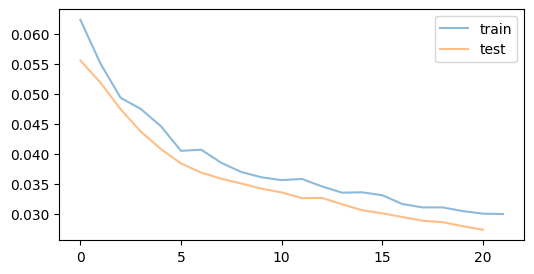

In [447]:
plt.figure(figsize=(6,3))
plt.plot(loss_list_train, alpha=0.5, label='train')
plt.plot(loss_list_test, alpha=0.5, label='test')
# plt.yscale('log')
plt.legend()
plt.savefig('images/R1AE_MNIST_Gumbell_torch.png')
plt.show()

### Reconstruction and distribution graphs

In [448]:
def inf_by_layers(model, x_batch):
    # forward pass with intermediate layers
    x_down = model.down(x_batch)
    B, C, H, W = x_down.shape
    x_flat = x_down.view(B,C*H*W)
    encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(x_flat)
    decoded_1d = model.low_rank.decoder(encoded_out_dim)
    # 2d upsampling
    decoded_2d_small = decoded_1d.view(B, C, H, W)
    decoded_2d = model.up(decoded_2d_small)

    return decoded_2d, encoded_out_dim, factors_probability

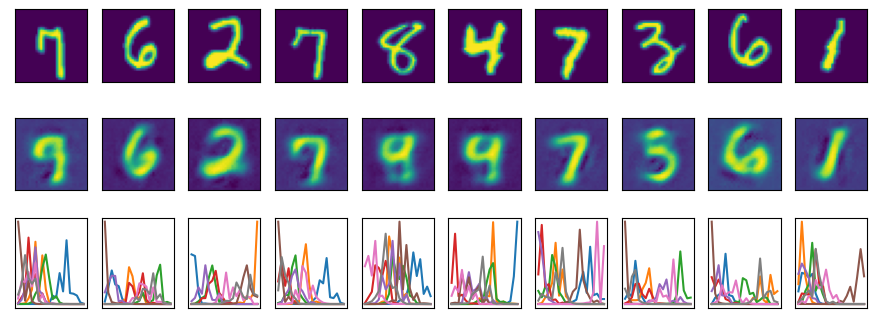

In [449]:
fig, axs = plt.subplots(3,10, figsize=(11,4))

for i in range(0,10):
    INDX=i+80
    #true
    
    #pred
    with torch.no_grad():
        model.eval()
        x_batch = X_full_test[INDX].unsqueeze(0).to(device)
        
        # plotting original images
        axs[0,i].imshow(x_batch[0,0].cpu().detach().numpy()) # mnist

        # forward pass with intermediate layers
        decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
        
    axs[1,i].imshow(decoded_2d.cpu().detach().numpy()[0,0]) # mnist

    
    # 1d probabilities
    for j in range(factors_probability.shape[1]):
        axs[2,i].plot(nn.Softmax(dim=-1)(factors_probability)[0,j,::].cpu().detach().numpy())
#         axs[2,i].set_ylim(-0.1,1.1)
        
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])

# plt.savefig('MNIST_softmax_plus_Reconstruction.png')
plt.show()

In [450]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, X_full_test.to(device))
    

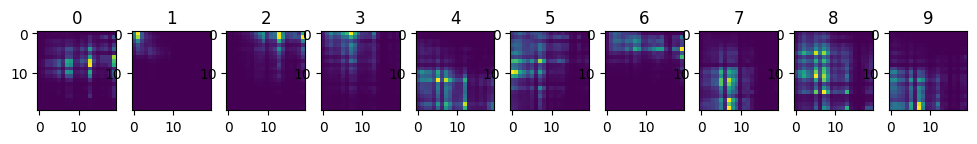

In [451]:
# plot
fig, axs = plt.subplots(1,10, figsize=(12,2))
fbs = nn.Softmax(dim=-1)(factors_probability)
for i in range(0,10):
    f1, f2 = fbs[::,0,::], fbs[::,1,::]
    probs = np.zeros((f1.shape[-1],f1.shape[-1]))
    # selecting the encoded distibution vectors
    f1_cls, f2_cls = f1[targets_test == i], f2[targets_test == i]
    for f1_vec, f2_vec in zip(f1_cls, f2_cls):
        probs += np.outer(f1_vec.cpu().detach().numpy(), f2_vec.cpu().detach().numpy())
            
    axs[i].imshow(probs)
#     axs[i].set_xticks(model.range.detach().numpy()/20)
#     axs[i].set_yticks(model.range.detach().numpy()/20)
    
    axs[i].set_title(f'{i}')

plt.savefig('MNIST_prob_2d_distribution.png')

plt.show()

# Visualization

In [226]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d_train, encoded_out_dim_train, factors_probability_train = inf_by_layers(model, X_full_train.to(device))
    decoded_2d_test, encoded_out_dim_test, factors_probability_test = inf_by_layers(model, X_full_test.to(device))  


### PCA

In [227]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

enc_pca_train = pca.fit_transform(encoded_out_dim_train.cpu().detach().numpy())
enc_pca_test = pca.fit_transform(encoded_out_dim_test.cpu().detach().numpy())

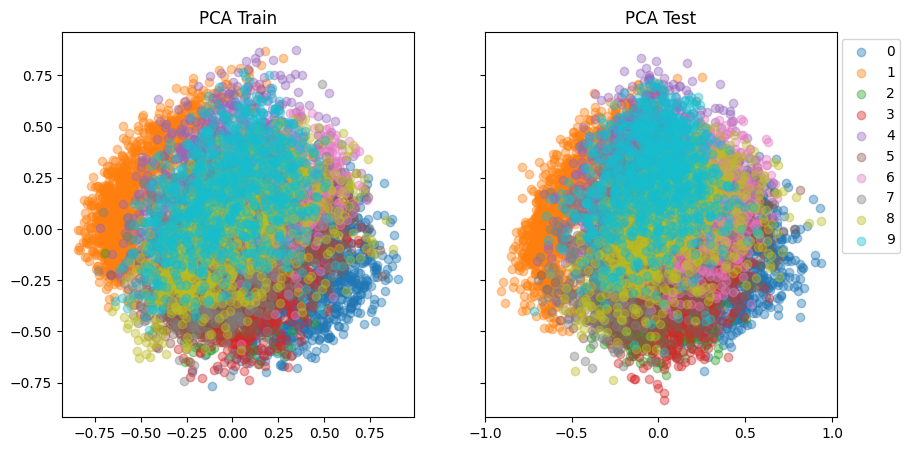

In [228]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    X_pca_train = enc_pca_train[targets == cls]
    axs[0].scatter(X_pca_train[::,0], X_pca_train[::,1], label=cls, alpha=0.4)
    
    X_pca_test = enc_pca_test[targets_test == cls]
    axs[1].scatter(X_pca_test[::,0], X_pca_test[::,1], label=cls, alpha=0.4)

axs[0].set_title('PCA Train')
axs[1].set_title('PCA Test')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.savefig('MNIST_Gumbell_PCA.png')
plt.show()

### T-SNE

In [229]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

enc_tsne_train = tsne.fit_transform(encoded_out_dim_train.cpu().detach().numpy())
enc_tsne_test = tsne.fit_transform(encoded_out_dim_test.cpu().detach().numpy())

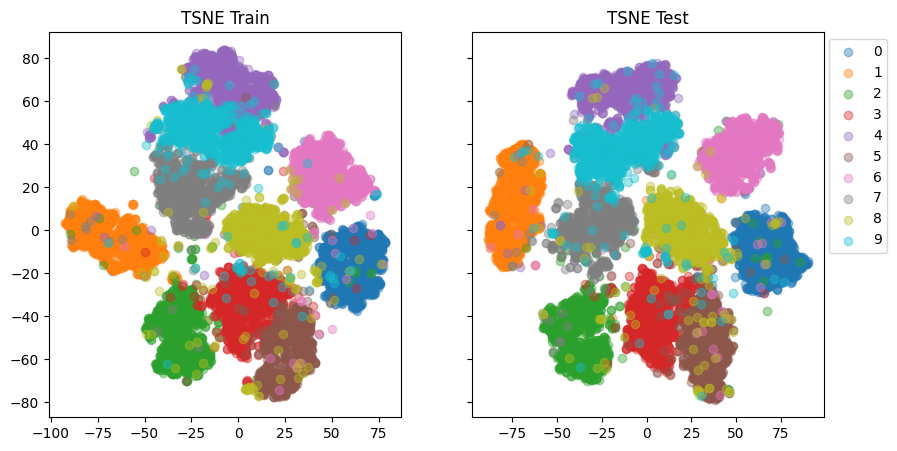

In [230]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    X_tsne_train = enc_tsne_train[targets == cls]
    axs[0].scatter(X_tsne_train[::,0], X_tsne_train[::,1], label=cls, alpha=0.4)
    
    X_tsne_test = enc_tsne_test[targets_test == cls]
    axs[1].scatter(X_tsne_test[::,0], X_tsne_test[::,1], label=cls, alpha=0.4)

axs[0].set_title('TSNE Train')
axs[1].set_title('TSNE Test')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.savefig('MNIST_Gumbell_TSNE.png')
plt.show()

# Generation

In [231]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d_train, encoded_out_dim_train, factors_probability_train = inf_by_layers(model, X_full_train.to(device))
    decoded_2d_test, encoded_out_dim_test, factors_probability_test = inf_by_layers(model, X_full_test.to(device))  


### Multivariate Gaussian Generation

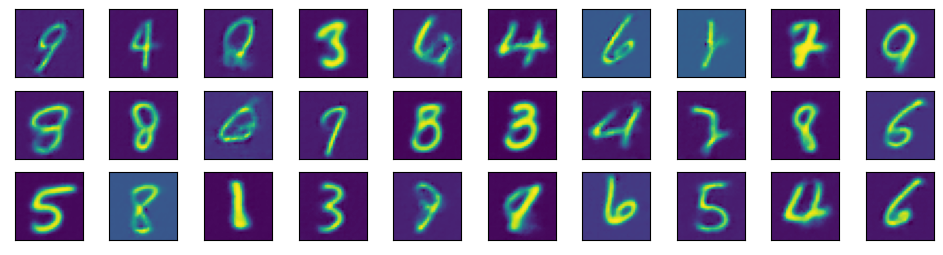

In [233]:
# plot
EMB_SIZE = 8

mean_vec = torch.mean(encoded_out_dim_train, dim=0)
std_vec = torch.std(encoded_out_dim_train, dim=0)

fig, axs = plt.subplots(3,10, figsize=(12,3))
for i in range(0,10):
    with torch.no_grad():
        model.eval()

        for j in range(3):
            rand = torch.randn(EMB_SIZE).to(device)*std_vec + mean_vec
            x_down = model.down(x_batch)
            B, C, H, W = (1,128,4,4)
            decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
            decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])



    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
#     axs[i].set_title(f'{i}')

plt.savefig('MNIST_Single_Gaussian_Generation.png')
plt.show()

### K-means Gaussian Generation

In [234]:
def generate_from_gaussians(mean_std_list, N_CLUSTERS, fixed_idx=None):
    if not fixed_idx:
        idx = torch.randint(low=0, high=N_CLUSTERS, size=(1,))
    else:
        idx = fixed_idx
    mean, std = mean_std_list[idx]
    rand = torch.randn(mean.shape)*std + mean
    return rand

In [235]:
enc_points_train = encoded_out_dim_train.cpu().detach().numpy()
enc_points_train.shape

(10000, 8)

In [164]:
# calculating best k
# from sklearn.cluster import KMeans
# cost =[]
# k_nums = [5,10,15,20,30,50,100]
# for i in k_nums:
#     KM = KMeans(n_clusters = i, max_iter = 500, n_init=5)
#     KM.fit(enc_points_train)
#     cost.append(KM.inertia_) 
# plt.figure(figsize=(4,2))
# plt.plot(k_nums, cost)
# plt.grid()
# plt.show()

In [257]:
from sklearn.cluster import KMeans
N_CLUSTERS = 30

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=100)
kmeans.fit(enc_points_train)

# filling list of gaussian means and stds
mean_std_list = []
for clstr_idx in np.unique(kmeans.labels_):
    mean = kmeans.cluster_centers_[clstr_idx]
    std = np.std(enc_points_train[kmeans.labels_== clstr_idx], axis=0)
    mean_std_list.append([torch.from_numpy(mean), torch.from_numpy(std)])

In [258]:
generate_from_gaussians(mean_std_list, N_CLUSTERS, fixed_idx=1)

tensor([0.0673, 0.3211, 0.5769, 0.1617, 0.3559, 0.3966, 0.4474, 0.7055])

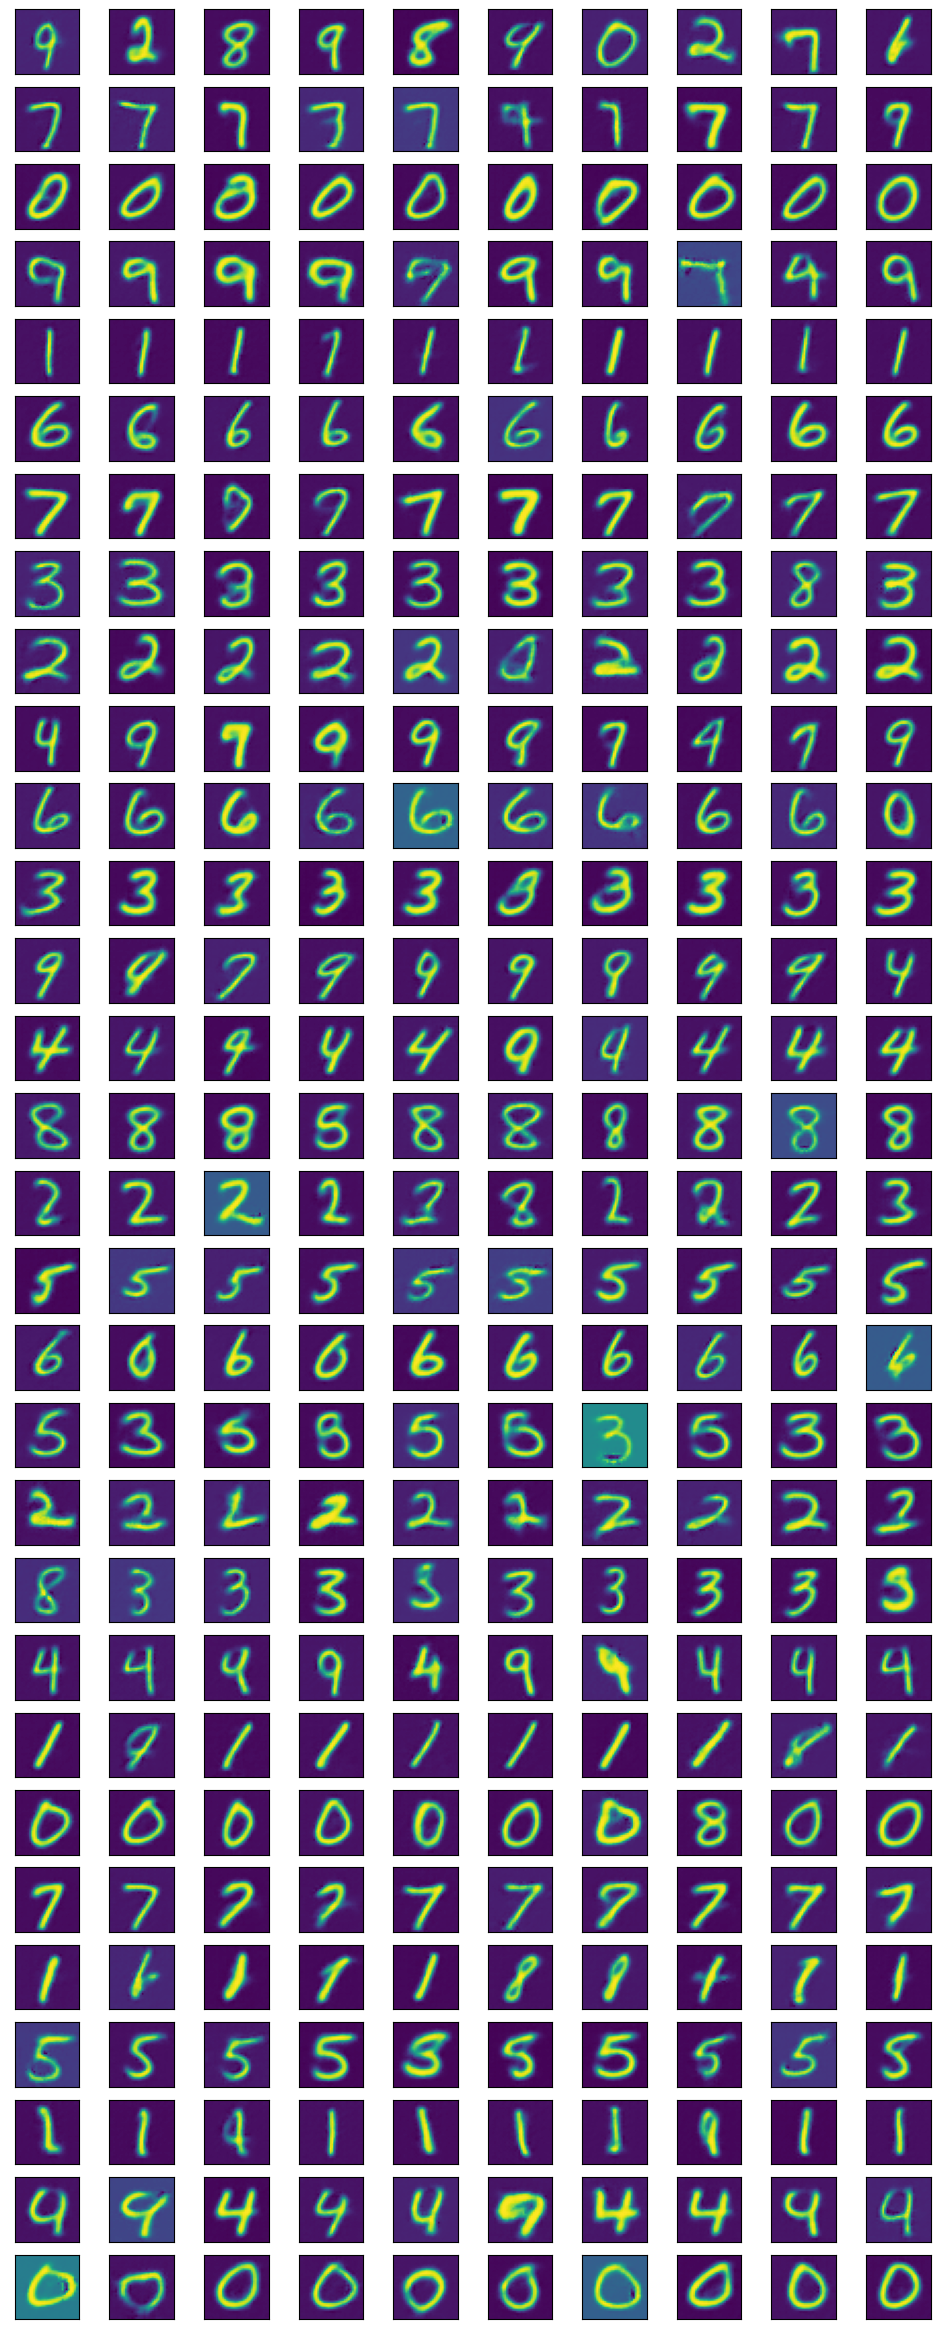

In [259]:
# plot
EMB_SIZE = 8

mean_vec = torch.mean(encoded_out_dim_train, dim=0)
std_vec = torch.std(encoded_out_dim_train, dim=0)

fig, axs = plt.subplots(N_CLUSTERS,10, figsize=(12,N_CLUSTERS))
for i in range(0,10):
    with torch.no_grad():
        model.eval()

        for j in range(N_CLUSTERS):
            rand = generate_from_gaussians(mean_std_list, N_CLUSTERS, fixed_idx=j)
            x_down = model.down(x_batch)
            B, C, H, W = (1,128,4,4)
            decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
            decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])

            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])

plt.savefig('MNIST_Multtiple_Gaussian_Generation.png')
plt.show()

### K-means Generation

In [260]:
def generate_from_clusters(clusters_tensor, grid, fixed_idx = None):
    if not fixed_idx:
        idx = torch.randint(low=0, high=N_CLUSTERS, size=(1,))
    else:
        idx = fixed_idx
    n_clust, enc_dim, n_bins = clusters_tensor.shape
    clusters_logits = torch.log(clusters_tensor + 1e-9)
    enc = gumbell_torch_sampling(clusters_logits, grid, temperature=0.5)
    return enc[idx]

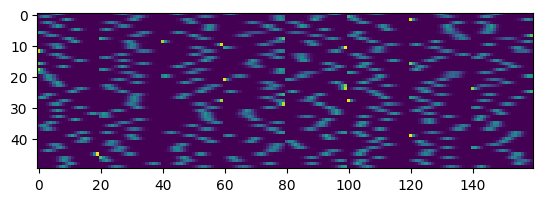

In [268]:
# probability flat matrix
from scipy.ndimage import gaussian_filter1d

probs_train = nn.Softmax(dim=-1)(factors_probability_train).cpu().detach().numpy()
probs_train = probs_train 
probs_train_smooth = gaussian_filter1d(probs_train, sigma=1.) # smoothing

prob_flat_train = probs_train.reshape(probs_train.shape[0], -1)
prob_flat_smooth_train = probs_train_smooth.reshape(probs_train_smooth.shape[0], -1)


plt.imshow(prob_flat_smooth_train[::200,::])
plt.show()

In [269]:
print(np.sum(np.isnan(prob_flat_train)))
print(np.sum(np.isinf(prob_flat_train)))
print(np.sum(prob_flat_train < 0))

0
0
0


In [270]:
# calculating best k
# from sklearn.cluster import KMeans
# cost =[]
# k_nums = [5,10,15,20,30,50,100,500,1000]
# for i in k_nums:
#     KM = KMeans(n_clusters = i, max_iter = 500, n_init=5)
#     KM.fit(prob_flat_train)
#     cost.append(KM.inertia_) 
# plt.figure(figsize=(4,2))
# plt.plot(k_nums, cost)
# plt.grid()
# plt.show()

In [271]:
from sklearn.cluster import KMeans
N_CLUSTERS = 30

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=100)

kmeans.fit(prob_flat_smooth_train)

KMeans(n_clusters=30, n_init=100)

In [275]:
.shape

(10000,)

In [276]:
kmeans_centroids = []
for clstr_idx in np.unique(kmeans.labels_):
    if clstr_idx == -1:
        continue
    centroid = np.mean(prob_flat_train[kmeans.labels_==clstr_idx], axis=0)
    kmeans_centroids.append(centroid)
np.array(kmeans_centroids).shape

(30, 160)

In [277]:
clusters_tensor = torch.from_numpy(np.array(kmeans_centroids)).view(N_CLUSTERS,8,20)

print(torch.sum(torch.isnan(clusters_tensor)))
print(torch.sum(torch.isinf(clusters_tensor)))
print(torch.sum(clusters_tensor < 0))
clusters_tensor[clusters_tensor<0] = 0.
print(torch.sum(clusters_tensor < 0))

tensor(0)
tensor(0)
tensor(0)
tensor(0)


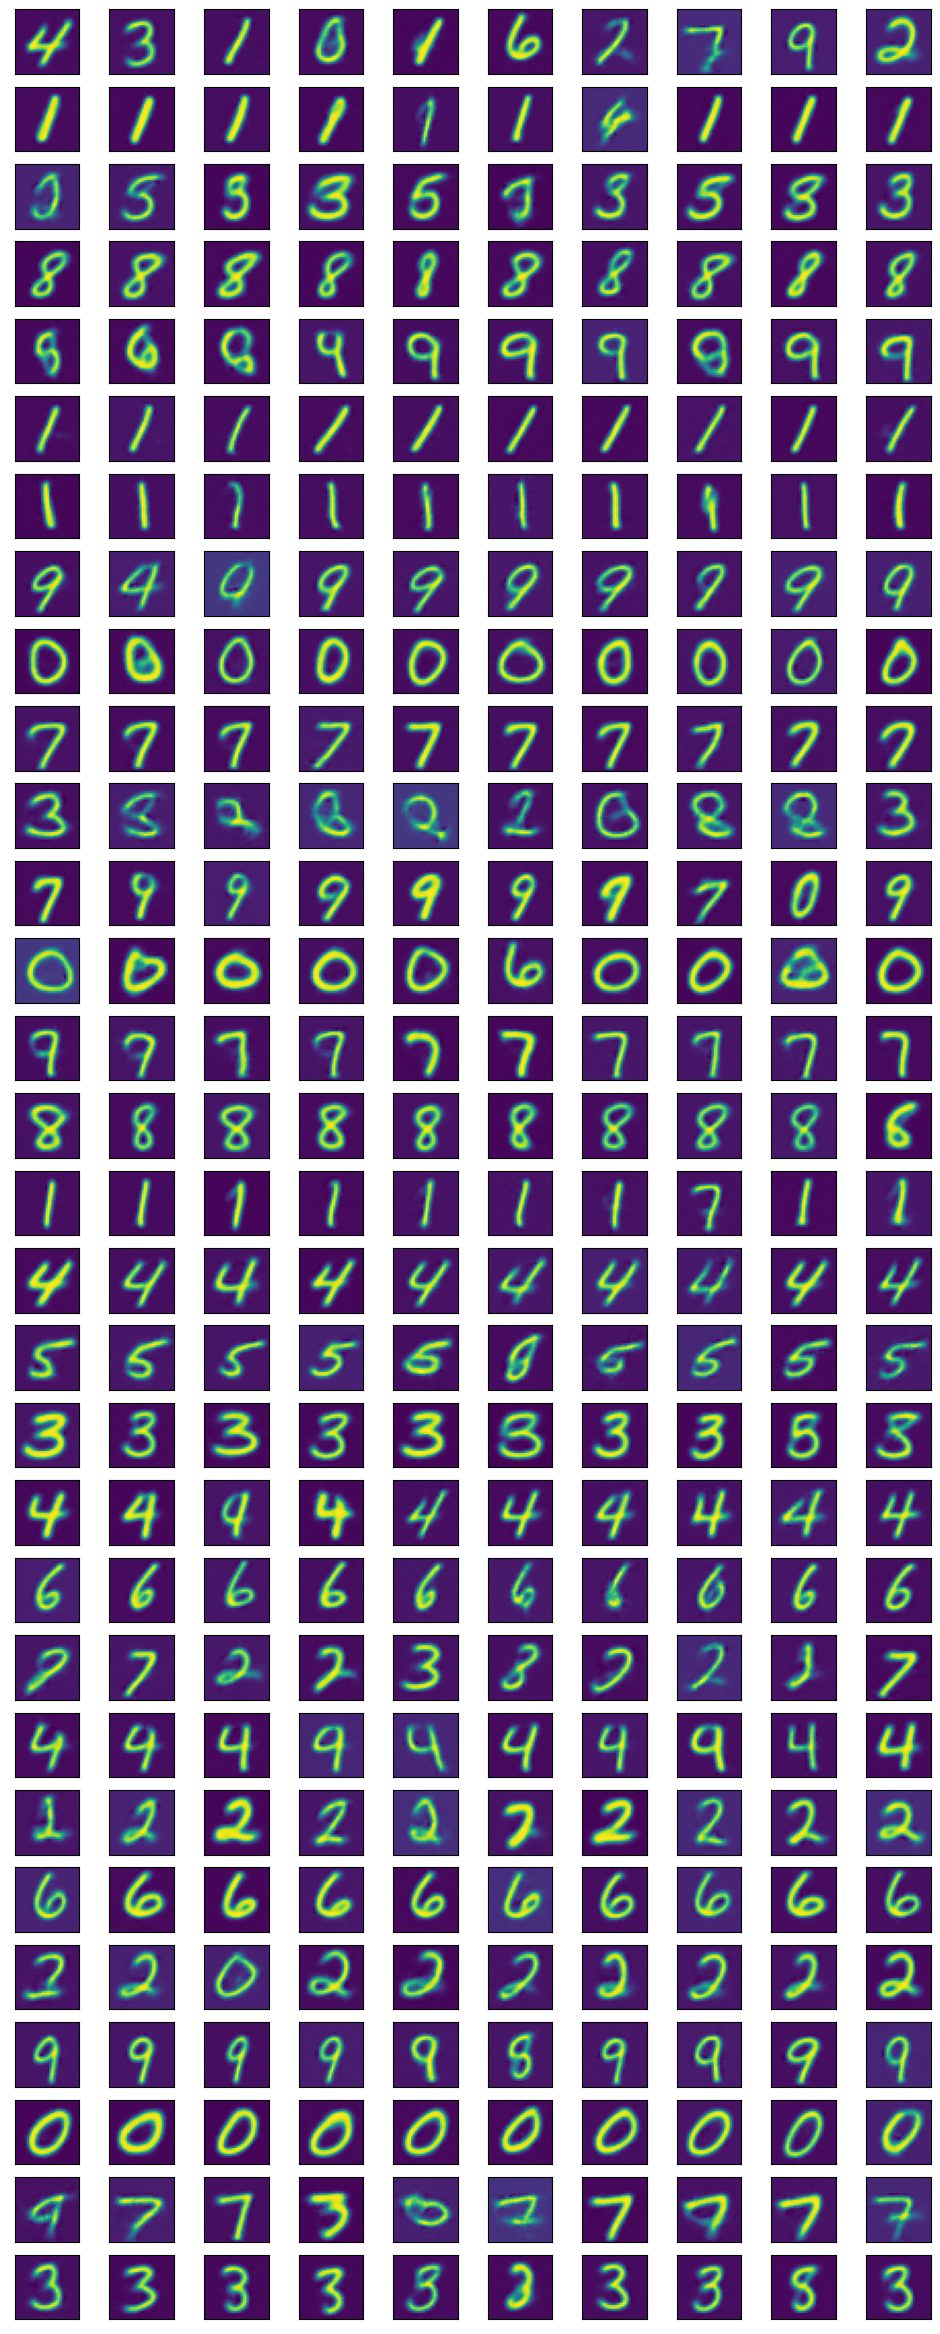

In [278]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(N_CLUSTERS,10, figsize=(12,N_CLUSTERS))
for i in range(0,10):
    with torch.no_grad():
        model.eval()

        for j in range(N_CLUSTERS):
            rand = generate_from_clusters(clusters_tensor, grid=torch.arange(1,21)/20, fixed_idx=j)
            x_down = model.down(x_batch)
            B, C, H, W = (1,128,4,4)
            decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
            decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])

            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])

plt.savefig('MNIST_K_means_Generation.png')
plt.show()

### Numbers transition

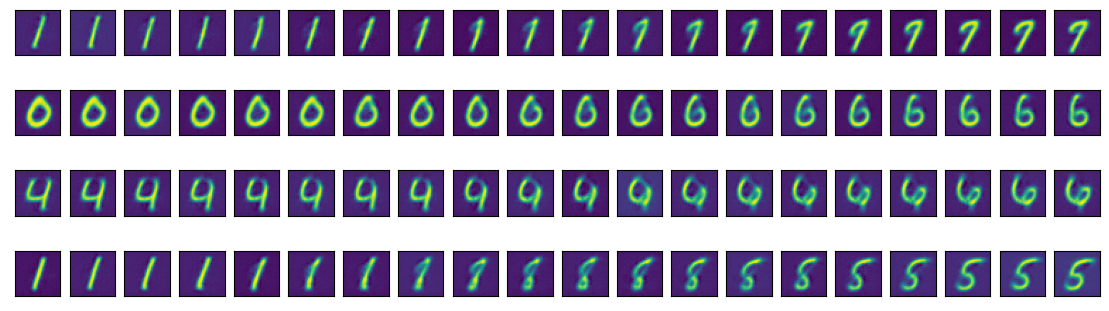

In [175]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(4,20, figsize=(14,4))
for i in range(0,20):
    with torch.no_grad():
        model.eval()
            
        for j in range(4):
            # encode two numbers
            # NUMBER 1
            IDX_1 = j+2
            x_down1 = model.down(X_full_test[IDX_1].unsqueeze(0).to(device))
            B, C, H, W = x_down1.shape
            x_flat1 = x_down1.view(B,C*H*W)
            encoded_inter_dim1 =                    model.low_rank.encoder(x_flat1)
            encoded_out_dim1, factors_probability1 = model.low_rank.low_rank_pants(encoded_inter_dim1)

            # NUMBER 2
            IDX_2 = j+20
            x_down2 = model.down(X_full_test[IDX_2].unsqueeze(0).to(device))
            B, C, H, W = x_down2.shape
            x_flat2 = x_down2.view(B,C*H*W)
            encoded_inter_dim2 =                    model.low_rank.encoder(x_flat2)
            encoded_out_dim2, factors_probability2 = model.low_rank.low_rank_pants(encoded_inter_dim2)

            # decode and plot
            new_encoded = (1-i/axs.shape[-1])*encoded_out_dim1 + (i/axs.shape[-1])*encoded_out_dim2
            decoded_inter_dim =  model.low_rank.intermediate_decoder(new_encoded)
            decoded_1d = model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])
plt.show()